In [40]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import seaborn as sns

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Users\HP\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [73]:
df = pd.read_csv(r'C:\Users\HP\Downloads\zp.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [74]:
df.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [75]:
df.describe()

,WAG_C_M
count,325.000000
mean,16076.616923
std,15307.461077
min,15.300000
25%,1716.000000
50%,11046.000000
75%,29346.000000
max,62239.000000


Text(0.5, 1.0, 'Сердняя зарплата в РФ 1993-2020')

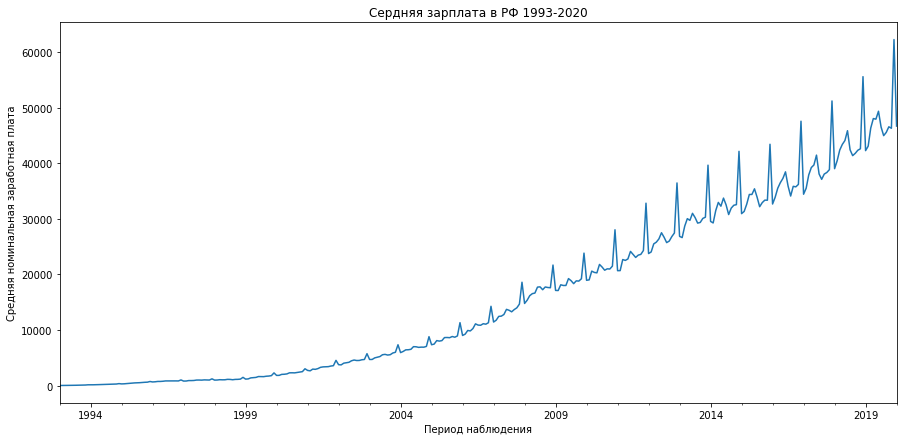

In [76]:
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
plt.ylabel(u'Средняя номинальная заработная плата')
plt.xlabel(u'Период наблюдения')
plt.title(u"Сердняя зарплата в РФ 1993-2020")

In [43]:
print('Минимальная зарплата и ее дата:')
print(df[df['WAG_C_M'] == df['WAG_C_M'].min()].values[0, 0])
print(df[df['WAG_C_M'] == df['WAG_C_M'].min()].index[0].date())

Минимальная зарплата и ее дата:
15.3
1993-01-01


In [44]:
print('Максимальная зарплата и ее дата:')
print(df[df['WAG_C_M'] == df['WAG_C_M'].max()].values[0, 0])
print(df[df['WAG_C_M'] == df['WAG_C_M'].max()].index[0].date())

Максимальная зарплата и ее дата:
62239.0
2019-12-01


In [45]:
print("Критерий Дики-Фуллера: p=") 
print(sm.tsa.stattools.adfuller(df.WAG_C_M)[1])

Критерий Дики-Фуллера: p=
0.9989583927514195


<Figure size 1080x720 with 0 Axes>

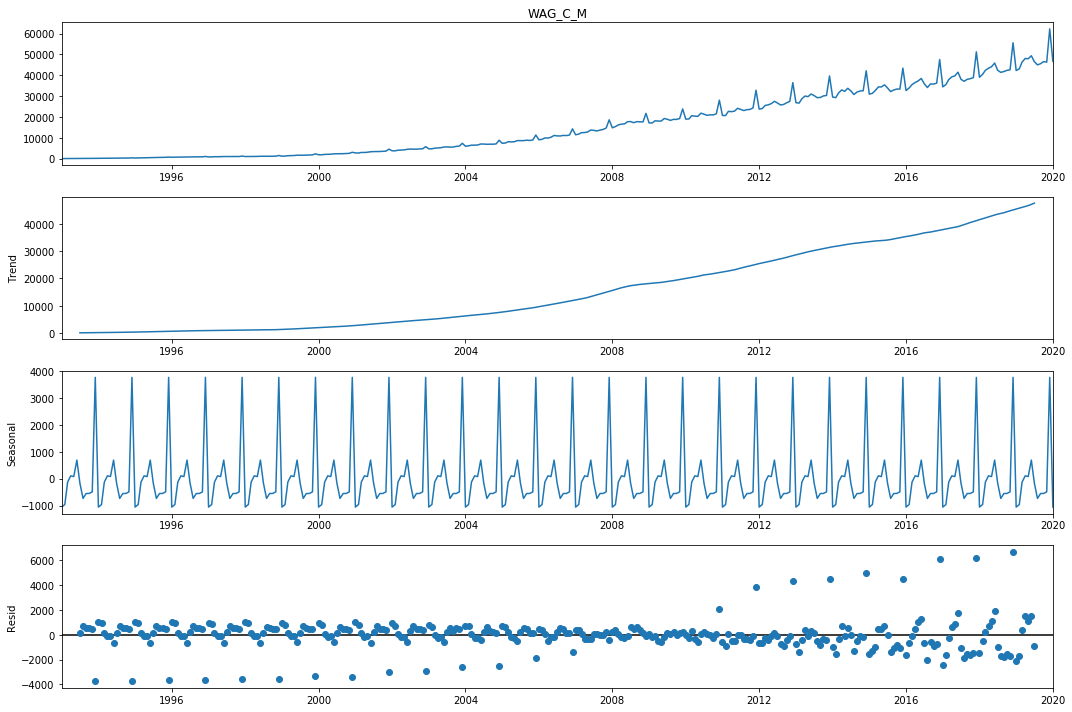

In [46]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M).plot()
plt.show()

Можно наблюдать тренд - плавное увеличение.
Сезонность - постоянный период у циклов.

Необходимо обеспечить стационарность. Стабилизируем дисперсию:

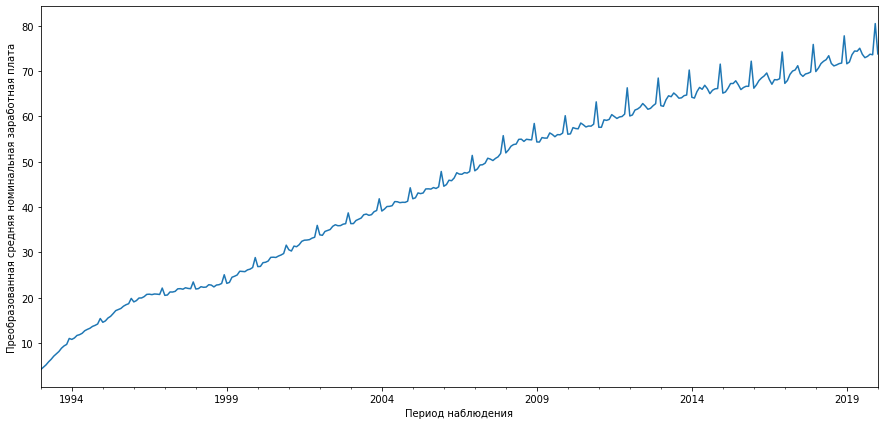

In [47]:
df['WAG_C_M_boxcox'], lmbda = stats.boxcox(df.WAG_C_M)
plt.figure(figsize(15,7))
df.WAG_C_M_boxcox.plot()
plt.ylabel(u'Преобразованная средняя номинальная заработная плата')
plt.xlabel(u'Период наблюдения')
plt.show()

In [48]:
print("Критерий Дики-Фуллера: p=") 
print(sm.tsa.stattools.adfuller(df.WAG_C_M_boxcox)[1])

Критерий Дики-Фуллера: p=
0.8107629410776809


Дифференцирование:

<Figure size 1080x720 with 0 Axes>

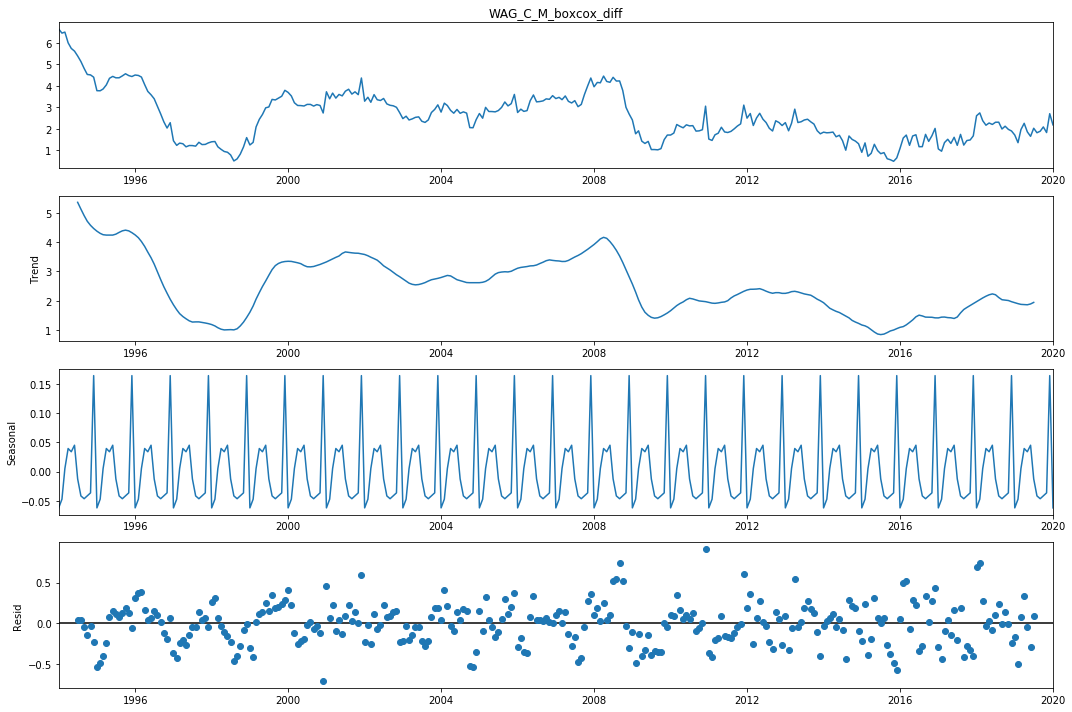

In [49]:
df['WAG_C_M_boxcox_diff'] = df.WAG_C_M_boxcox - df.WAG_C_M_boxcox.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M_boxcox_diff[12:]).plot()
plt.show()

In [50]:
print("Критерий Дики-Фуллера: p=") 
print(sm.tsa.stattools.adfuller(df.WAG_C_M_boxcox_diff[12:])[1])

Критерий Дики-Фуллера: p=
0.11735437835950685


<Figure size 1080x720 with 0 Axes>

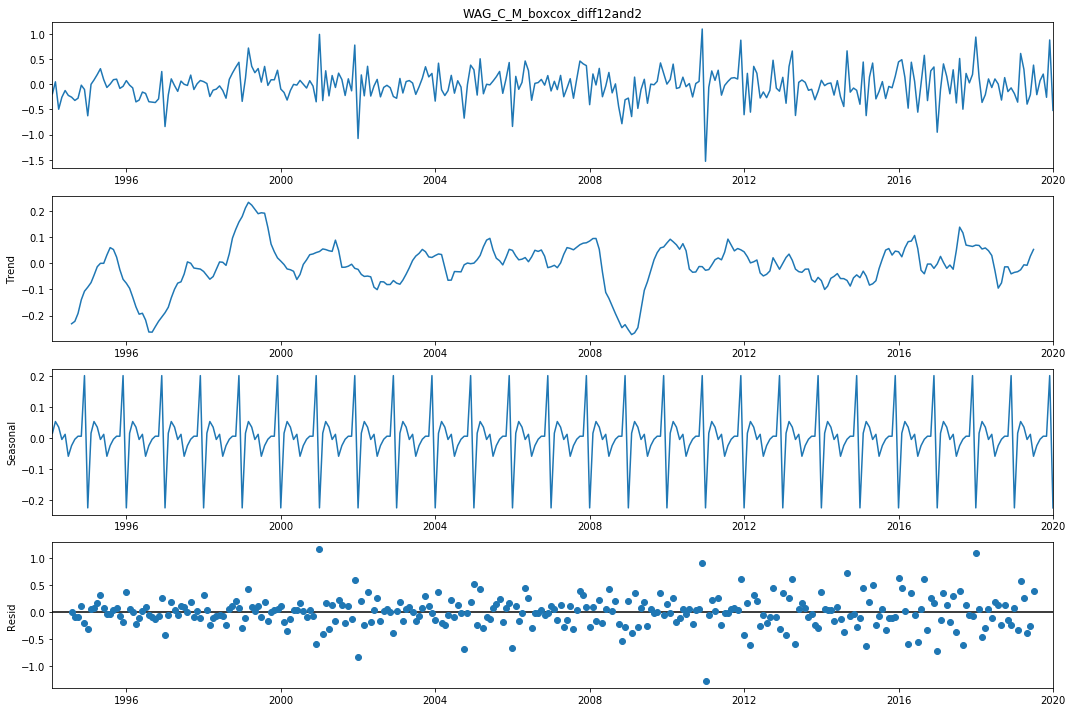

In [51]:
df['WAG_C_M_boxcox_diff12and2'] = df.WAG_C_M_boxcox_diff - df.WAG_C_M_boxcox_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M_boxcox_diff12and2[13:]).plot() 
plt.show()

In [52]:
print("Критерий Дики-Фуллера: p=") 
print(sm.tsa.stattools.adfuller(df.WAG_C_M_boxcox_diff12and2[13:])[1])

Критерий Дики-Фуллера: p=
3.704287890779676e-10


После преобразований был получен стационарный ряд.

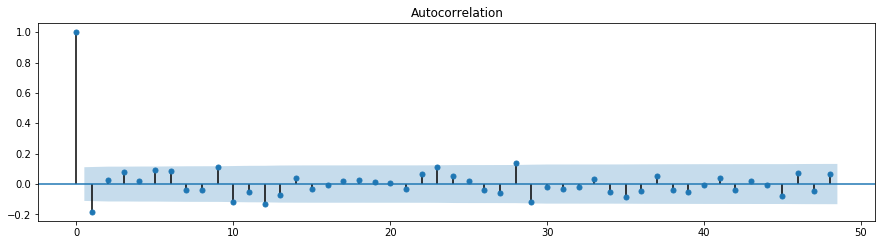

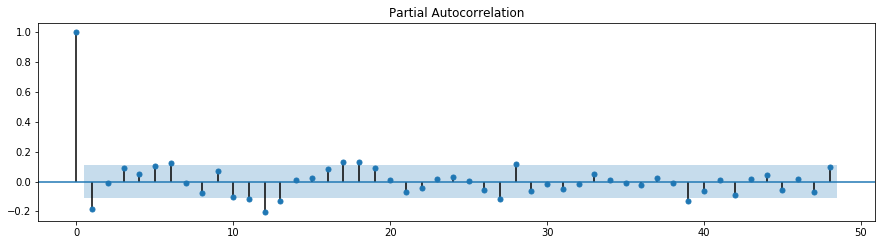

In [53]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.WAG_C_M_boxcox_diff12and2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.WAG_C_M_boxcox_diff12and2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [54]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 4)
D=1
Qs = range(0, 1)

In [56]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print("Количество комбинаций параметров:")
print(len(parameters_list))

Количество комбинаций параметров:
16


In [58]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df.WAG_C_M_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:')
        print(param)
        continue
    aic = model.aic
    #лучшая модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 30.7 s


In [60]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
9   (1, 0, 1, 0)  155.342801
5   (0, 1, 1, 0)  155.918169
10  (1, 0, 2, 0)  156.001758
6   (0, 1, 2, 0)  156.648339
13  (1, 1, 1, 0)  157.231019


In [61]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     WAG_C_M_boxcox   No. Observations:                  325
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 -74.671
Date:                            Sun, 24 May 2020   AIC                            155.343
Time:                                    12:38:54   BIC                            166.572
Sample:                                01-01-1993   HQIC                           159.831
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2157      0.042     -5.082      0.000      -0.299      -0.133
ar.S.L12      -0.1840      0.042   

Критерий Стьюдента: p=
0.23994958524839088
Критерий Дики-Фуллера: p=
2.6614906071730024e-06


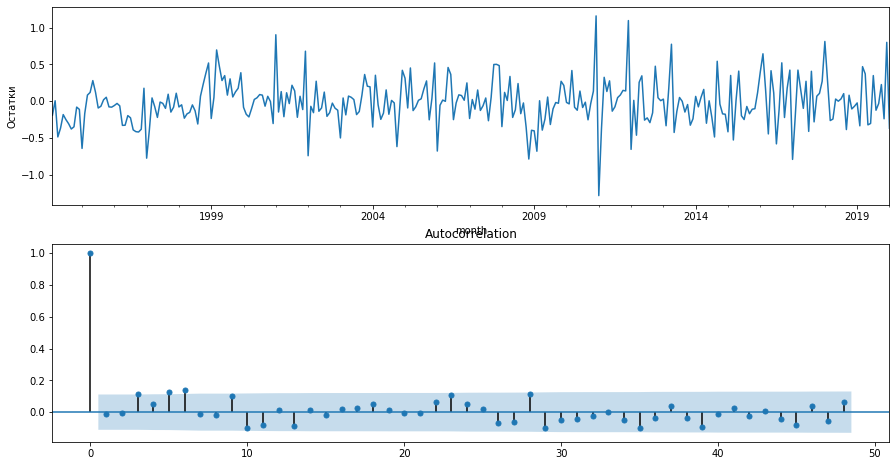

In [63]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Остатки')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=")
print(stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=")
print(sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

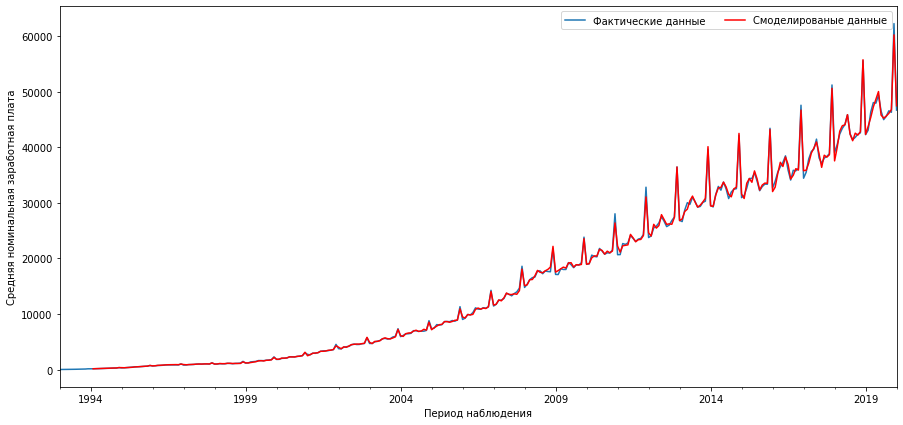

In [64]:
warnings.filterwarnings('ignore')
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
plot1 = df.WAG_C_M.plot()
plot2 = df.model[13:].plot(color='r')
plt.ylabel(u'Средняя номинальная заработная плата')
plt.xlabel(u'Период наблюдения')
plt.legend( [u'Фактические данные', u'Смоделированые данные'], loc=1, ncol = 2, prop={'size':10})
pylab.show()
warnings.filterwarnings('default')

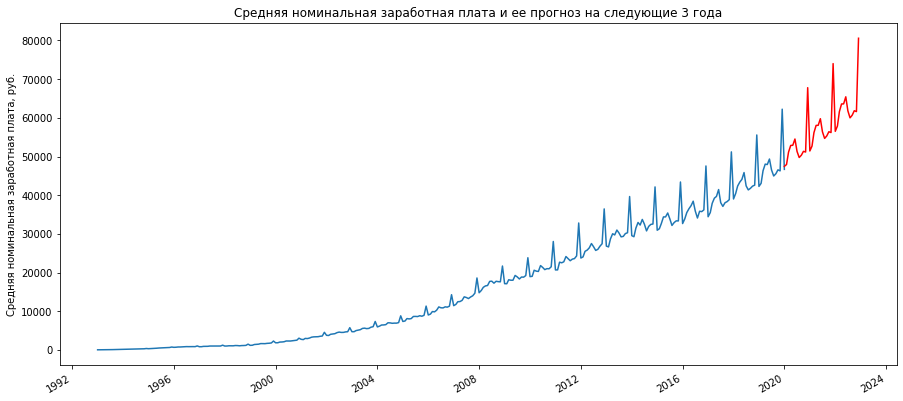

In [71]:
df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2020-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=324, end=363), lmbda)

plt.figure(figsize(15,7))
df2.WAG_C_M.plot()
df2.forecast.plot(color='r')
plt.ylabel(u'Средняя номинальная заработная плата, руб.')
plt.title(u'Средняя номинальная заработная плата и ее прогноз на следующие 3 года')
pylab.show()